In [1]:
from __future__ import print_function
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math
import itertools
from matplotlib import pyplot as plt
import IPython.display as display
%matplotlib inline

In [2]:
batch_size = 30

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

Files already downloaded


In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x)
        return out

In [31]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out

In [32]:
discriminator = Discriminator()
generator = Generator()

In [33]:
#criterion = nn.BCELoss()
lr = 0.0002
g_optimizer = optim.RMSprop(generator.parameters(), lr=5e-5)
d_optimizer = optim.RMSprop(discriminator.parameters(), lr=5e-5)

# d_optimizer = torch.optim.SGD(discriminator.parameters(), lr=lr)
# g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

In [34]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs_r = discriminator(images)
    real_score = outputs
    
    outputs_f = discriminator(fake_images) 
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = -(torch.mean(outputs_r) - torch.mean(outputs_f))
    d_loss.backward()
    d_optimizer.step()
    for p in discriminator.parameters():
        p.data.clamp_(-0.01, 0.01)
    return d_loss, real_score, fake_score

In [35]:
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = -torch.mean(discriminator_outputs)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [36]:
# draw samples from the input distribution to inspect the generation on training 
num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, 100))

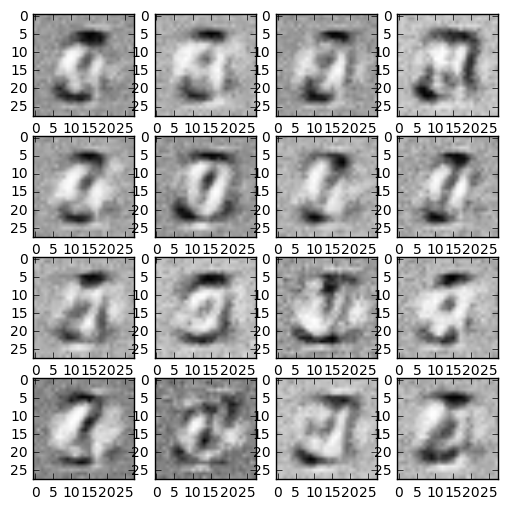

Epoch [20/200], Step[900/2000], d_loss: -0.0076, g_loss: -0.0071, D(x): 0.01, D(G(z)): 0.01


In [ ]:
# set number of epochs and initialize figure counter
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].axis('off')


num_epochs = 200
num_batches = len(train_loader)
num_fig = 0


for epoch in range(num_epochs):
    for n, (images, _) in enumerate(train_loader):
        images = Variable(images)
        real_labels = Variable(torch.ones(images.size(0)))
        
        # Sample from generator
        noise = Variable(torch.randn(images.size(0), 100))
        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0)))
        
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        
        if n % 5 == 0:
        # Sample again from the generator and get output from discriminator
            noise = Variable(torch.randn(images.size(0), 100))
            fake_images = generator(noise)
            outputs = discriminator(fake_images)

            # Train the generator
            g_loss = train_generator(generator, outputs, real_labels)
        
        if (n+1) % 100 == 0:
            test_images = generator(test_noise)
            
            for k in range(num_test_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            num_fig += 1
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
                  'D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch + 1, num_epochs, n+1, num_batches, d_loss.data[0], g_loss.data[0],
                    real_score.data.mean(), fake_score.data.mean()))